# Convolutional Neural Networks and Computer Vision with TensorFlow

For example, you might want to:

* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use CNNs.

### What we're going to cover
Specifically, we're going to go through the follow with TensorFlow:

* Getting a dataset to work with
* Architecture of a convolutional neural network
* A quick end-to-end example (what we're working towards)
* Steps in modelling for binary image classification with CNNs
  * Becoming one with the data
  * Preparing data for modelling
  * Creating a CNN model (starting with a baseline)
  * Fitting a model (getting it to find patterns in our data)
  * Evaluating a model
  * Improving a model
  * Making a prediction with a trained model
* Steps in modelling for multi-class image classification with CNNs
* Same as above (but this time with a different dataset)

## Get the dataset

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the <a href="https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/" target=blank>Food-101 dataset</a>, a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

<a href="https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip" target=blank><h3>>> DATA SOURCE << </h3></a>

In [1]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

### Inspect the data

* A train directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A test directory with the same structure as the train directory

In [2]:
!dir pizza_steak

 Volume in drive C has no label.
 Volume Serial Number is 80C8-EDA2

 Directory of C:\Users\Bolaji\Desktop\Tensorflow Developer Certificate\tensorflow_fundamentals\pizza_steak

02/20/2023  05:30 PM    <DIR>          .
02/20/2023  06:51 PM    <DIR>          ..
02/20/2023  05:30 PM    <DIR>          test
02/20/2023  05:30 PM    <DIR>          train
               0 File(s)              0 bytes
               4 Dir(s)  56,542,187,520 bytes free


In [3]:
import os

for path, folders, flles in os.walk('pizza_steak/'):
    print(f"There are {len(folders)} directories and {len(flles)} images in '{path}'.")

There are 2 directories and 0 images in 'pizza_steak/'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test\pizza'.
There are 0 directories and 250 images in 'pizza_steak/test\steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train\pizza'.
There are 0 directories and 750 images in 'pizza_steak/train\steak'.


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_pizza_images_train = len(os.listdir("pizza_steak/train/pizza"))

print(f'There are {num_steak_images_train} steak images for training and')
print(f'There are {num_pizza_images_train} pizza images for training')

There are 750 steak images for training and
There are 750 pizza images for training


In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (384, 512, 3)


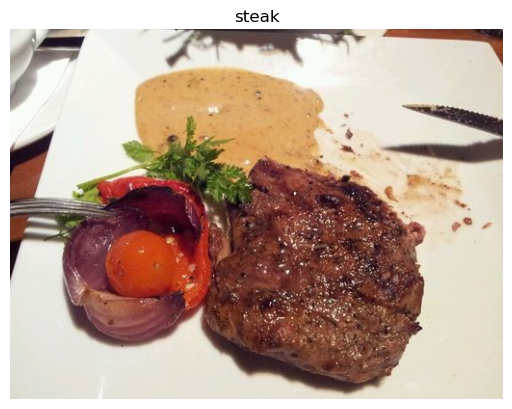

In [7]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

Image shape: (512, 382, 3)


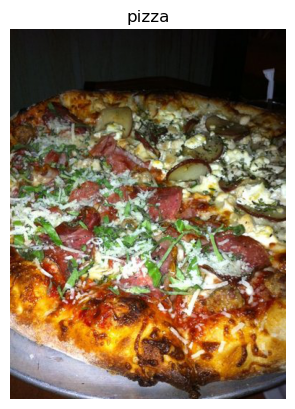

In [8]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="pizza")

In [9]:
img.dtype

dtype('uint8')

In [10]:
img.shape

(512, 382, 3)

In [11]:
img

array([[[22, 17, 13],
        [22, 17, 13],
        [22, 17, 13],
        ...,
        [ 4,  4,  2],
        [ 4,  4,  2],
        [ 5,  5,  3]],

       [[22, 17, 13],
        [23, 18, 14],
        [23, 18, 14],
        ...,
        [ 4,  4,  2],
        [ 4,  4,  2],
        [ 5,  5,  3]],

       [[23, 18, 14],
        [23, 18, 14],
        [23, 18, 14],
        ...,
        [ 4,  4,  2],
        [ 4,  4,  2],
        [ 5,  5,  3]],

       ...,

       [[51, 23,  9],
        [51, 23,  9],
        [51, 23,  9],
        ...,
        [47, 45, 58],
        [49, 46, 57],
        [52, 49, 60]],

       [[52, 23,  9],
        [51, 22,  8],
        [50, 22,  8],
        ...,
        [50, 48, 59],
        [49, 46, 57],
        [50, 47, 58]],

       [[49, 20,  6],
        [48, 19,  5],
        [48, 19,  5],
        ...,
        [52, 50, 61],
        [50, 47, 58],
        [49, 46, 57]]], dtype=uint8)

Looking at the image shape more closely, you'll see it's in the form (Width, Height, Colour Channels).

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

You'll notice all of the values in the img array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value red=0, green=0, blue=255 will look very blue.

So when we build a model to differentiate between our images of pizza and steak, it will be finding patterns in these different pixel values which determine what each class looks like.

In [12]:
# Get all the pixel values between 0 & 1
img/255.  

array([[[0.08627451, 0.06666667, 0.05098039],
        [0.08627451, 0.06666667, 0.05098039],
        [0.08627451, 0.06666667, 0.05098039],
        ...,
        [0.01568627, 0.01568627, 0.00784314],
        [0.01568627, 0.01568627, 0.00784314],
        [0.01960784, 0.01960784, 0.01176471]],

       [[0.08627451, 0.06666667, 0.05098039],
        [0.09019608, 0.07058824, 0.05490196],
        [0.09019608, 0.07058824, 0.05490196],
        ...,
        [0.01568627, 0.01568627, 0.00784314],
        [0.01568627, 0.01568627, 0.00784314],
        [0.01960784, 0.01960784, 0.01176471]],

       [[0.09019608, 0.07058824, 0.05490196],
        [0.09019608, 0.07058824, 0.05490196],
        [0.09019608, 0.07058824, 0.05490196],
        ...,
        [0.01568627, 0.01568627, 0.00784314],
        [0.01568627, 0.01568627, 0.00784314],
        [0.01960784, 0.01960784, 0.01176471]],

       ...,

       [[0.2       , 0.09019608, 0.03529412],
        [0.2       , 0.09019608, 0.03529412],
        [0.2       , 0

### An end-to-end example

The code in the following cell replicates and end-to-end way to model our pizza_steak dataset with a convolutional neural network (CNN) using the components listed above.

There will be a bunch of things you might not recognize but step through the code yourself and see if you can figure out what it's doing.

We'll go through each of the steps later on in the notebook.

For reference, the model we're using replicates TinyVGG, the computer vision architecture which fuels the <a href="https://poloclub.github.io/cnn-explainer/" taget=blank>CNN explainer webpage</a>.

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


train_dir = 'pizza_steak/train'
valid_dir = 'pizza_steak/test'

# Import data from directory and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, target_size=(224, 224),
                                              class_mode='binary', seed = 42, batch_size=32)

valid_data = valid_datagen.flow_from_directory(directory=valid_dir, target_size=(224, 224),
                                              class_mode='binary', seed = 42, batch_size=32)


# Build the model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters= 10, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_1.compile(loss= 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

history_1 = model_1.fit(train_data, epochs = 5, steps_per_epoch=len(train_data),
                       validation_data=valid_data, validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 119s 2s/step - loss: 0.6367 - accuracy: 0.6460 - val_loss: 0.4330 - val_accuracy: 0.8220
Epoch 2/5
47/47 [==============================] - 135s 3s/step - loss: 0.4451 - accuracy: 0.7953 - val_loss: 0.3527 - val_accuracy: 0.8500
Epoch 3/5
47/47 [==============================] - 116s 2s/step - loss: 0.3969 - accuracy: 0.8300 - val_loss: 0.3826 - val_accuracy: 0.8160
Epoch 4/5
47/47 [==============================] - 122s 3s/step - loss: 0.3907 - accuracy: 0.8220 - val_loss: 0.3251 - val_accuracy: 0.8740
Epoch 5/5
47/47 [==============================] - 128s 3s/step - loss: 0.3343 - accuracy: 0.8660 - val_loss: 0.2945 - val_accuracy: 0.8820


In [14]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [15]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis


# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [28]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(valid_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [29]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

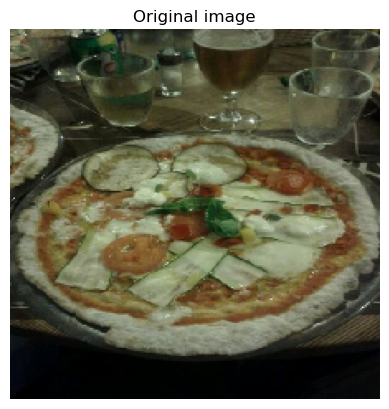

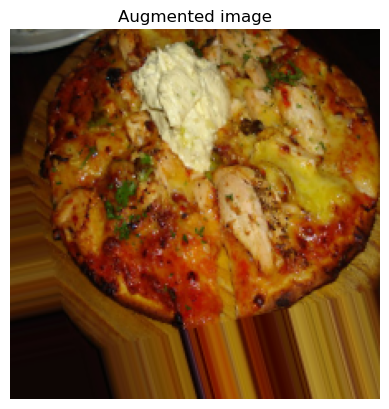

In [30]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [31]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [32]:
# Create the model (same as model_5 and model_6)
model_7 = tf.keras.Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 99s 2s/step - loss: 0.6373 - accuracy: 0.6427 - val_loss: 0.5170 - val_accuracy: 0.7300
Epoch 2/5
47/47 [==============================] - 94s 2s/step - loss: 0.5096 - accuracy: 0.7553 - val_loss: 0.4117 - val_accuracy: 0.8080
Epoch 3/5
47/47 [==============================] - 93s 2s/step - loss: 0.5017 - accuracy: 0.7700 - val_loss: 0.3857 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 101s 2s/step - loss: 0.4858 - accuracy: 0.7693 - val_loss: 0.3536 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 95s 2s/step - loss: 0.4649 - accuracy: 0.7900 - val_loss: 0.3210 - val_accuracy: 0.8740


In [33]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

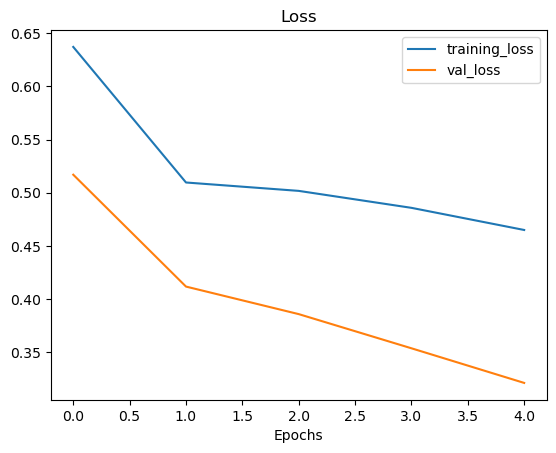

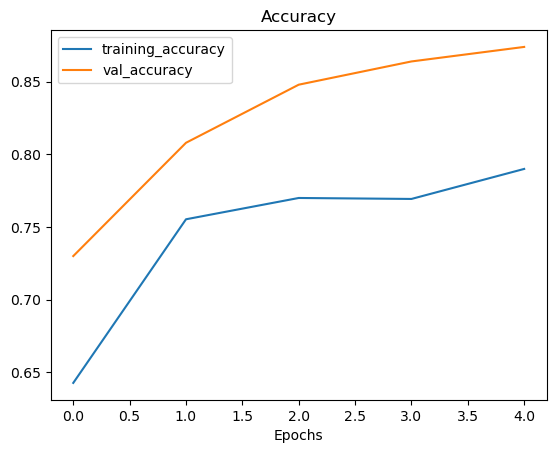

In [34]:
# Check out the TinyVGG model performance
plot_loss_curves(history_7)

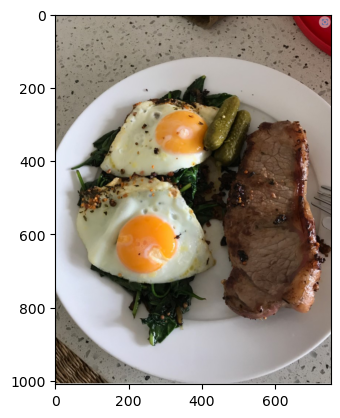

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

steak = mpimg.imread('steak.jpg')
plt.imshow(steak)

In [38]:
steak.shape

(1010, 753, 3)

In [37]:
model_7.predict(tf.expand_dims(steak))

TypeError: Missing required positional argument

In [39]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [40]:
steak = load_and_prep_image('steak.jpg')

In [41]:
steak.shape

TensorShape([224, 224, 3])

In [42]:
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.15255323, 0.15326226, 0.14329202],
        [0.6163078 , 0.6163078 , 0.57283795],
        [0.6543155 , 0.63938206, 0.59549195],
        ...,
        [0.46757436, 0.08584709, 0.09303357],
        [0.479934  , 0.0604779 , 0.08908135],
        [0.45178607, 0.05810608, 0.10826364]],

       [[0.14746143, 0.14996491, 0.13035707],
        [0.64944845, 0.6416053 , 0.59241945],
        [0.63988054, 0.62429345, 0.57954854],
        ...,
        [0.51676524, 0.03802848, 0.07964235],
        [0.5562148 , 0.02724974, 0.0742559 ],
        [0.5423729 , 0.03561783, 0.06304552]],

       [[0.16801368, 0.16480114, 0.1430662 ],
        [0.6253998 , 0.6175567 , 0.5623221 ],
        [0.66445017, 0.64204997, 0.5860188 ],
        ...,
        [0.7671635 , 0.5124851 , 0.5636206 ],
        [0.6581376 , 0.25792816, 0.3348221 ],
        [0.5449303 , 0.03264535, 0.06831749]],

       ...,

       [[0.15001696, 0.11580827, 0.09057193],
        [0.54

In [45]:
pred = model_7.predict(tf.expand_dims(steak, axis = 0))

1/1 [==============================] - 0s 206ms/step


array([[0.7998503]], dtype=float32)

In [46]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [52]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 0s 111ms/step


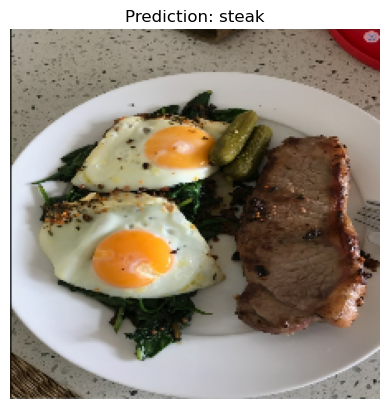

In [53]:
pred_and_plot(model_7, 'steak.jpg', class_names)